# Bandit Algorithms
This notebook aims to leverage on bandit algorithms such as Epsilon-Decay, Annealing Softmax, UCB1, Bayesian UCB and Thompson Sampling to evaluate its performance in recommending beers.

*Prepared by: Chan Cheah Cha, Chua Kai Bing, Goh Jia Yi, Lim Jia Qi, Tan Zen Wei*

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import random
import math
import os
import matplotlib.pyplot as plt
from scipy.stats import invgamma
plt.style.use('ggplot')

In [ ]:
# Setting paths
root = '/content/gdrive/MyDrive/BT4014/Codes/Data/'
bandit_root = root + 'Bandit/'

In [ ]:
# Import data
df = pd.read_csv(root + 'beer_matrix_100.csv')
df.head()

,Citra DIPA,Cantillon Blåbær Lambik,Heady Topper,Deviation - Bottleworks 9th Anniversary,Trappist Westvleteren 12,Pliny The Younger,Founders CBS Imperial Stout,Live Oak HefeWeizen,Portsmouth Kate The Great,Rare Bourbon County Stout,Duck Duck Gooze,Reality Czeck,Weihenstephaner Hefeweissbier,Trappist Westvleteren 8,Zombie Dust,Masala Mama India Pale Ale,Vanilla Bean Aged Dark Lord,Kuhnhenn Bourbon Barrel Fourth Dementia,Cable Car,The Abyss,Unplugged Bohemian Lager,Sculpin India Pale Ale,Edward Pale Ale,Ephraim,Isabelle Proximus,Andechser Doppelbock Dunkel,Abner Imperial IPA,Supplication,Abrasive Ale,Czar Jack Imperial Stout,Parabola,Brute,Cantillon Lou Pepe - Gueuze,Silva Stout,Founders KBS (Kentucky Breakfast Stout),Gumballhead,Tröegs Nugget Nectar,White Rajah,Temptation,Bell's Black Note Stout,...,Trappistes Rochefort 10,Southampton Saison,"St. Bernardus Abt 12 (60th Anniversary ""Special Edition"")",Furious,Beatification,Exponential Hoppiness,Sanctification,Cantillon Cuvée Des Champions,Alpha King Pale Ale,Great Lakes Edmund Fitzgerald Porter,Dreadnaught IPA,The Event Horizon,Knuckle Sandwich,St. Bernardus Abt 12,Lunch,Schneider Weisse Weizenhell (Hefeweizen),Cantillon Lou Pepe - Kriek,Weihenstephaner Hefeweissbier Dunkel,Bourbon County Brand Coffee Stout,Barrel Aged Sexual Chocolate,Bitter Monk,Saison - Brett,Cuvee De Castleton,Devil Over A Barrel - Bourbon Barrel-Aged Coffee Imperial Oatmeal Porter,AleSmith IPA,Matt,Oak Aged Dark Lord Imperial Stout,Firestone 13 - Anniversary Ale,Bitter Brewer,Ayinger Celebrator Doppelbock,La Fin Du Monde,Moon Man,Darkness,Daisy Cutter Pale Ale,Cadillac Mountain Stout,Great Lakes Dortmunder Gold,Wet,Ivan The Terrible,Consecration,Hop Trip (Bond Street Series)
0,0.0,0.0,0.0,0.0,4.5,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,4.0,4.5,0.0,4.5,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,4.5,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,5.0,4.5,5.0,0.0,5.0,0.0,4.5,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,4.5,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,4.5,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,5.0,4.5,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,4.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.shape

(10437, 100)

## Define Arguments, Arms and Methods

In [ ]:
# Initialization of arguments
N_SIMULATIONS = 200
n_steps = df.shape[0]
n_arms = df.shape[1]
N_SIMULATIONS, n_steps, n_arms

(200, 10437, 100)

In [ ]:
test_mean = df.mean().tolist()
test_std = df.std().tolist()

In [ ]:
## Define arms
class GaussianArm():
    """Arm representing Beer"""
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def draw(self):
        reward = np.random.normal(self.mean, self.std)
        # Setting limit for reward returned
        if reward > 5:
            return 5
        elif reward < 0:
            return 0
        return reward

In [ ]:
# Initialisation of arms
arms = list(map(lambda mean, std: GaussianArm(mean, std), test_mean, test_std))

In [ ]:
## Define test algorithm
def test_algorithm(algo, arms, num_sims, horizon):
    chosen_arms = [0.0 for i in range(num_sims * horizon)]
    rewards = [0.0 for i in range(num_sims * horizon)]
    cumulative_rewards = [0.0 for i in range(num_sims * horizon)]
    sim_nums = [0.0 for i in range(num_sims * horizon)]
    times = [0.0 for i in range(num_sims * horizon)]
    
    for sim in range(num_sims):
        print(sim, end=" ")
        sim = sim + 1
        algo.initialize (len(arms))
        
        for t in range(horizon):
            t = t + 1
            index = (sim - 1) * horizon + t -1 
            sim_nums[index] = sim
            times[index] = t
            
            chosen_arm = algo.select_arm()
            chosen_arms[index] = chosen_arm
            
            reward = arms[chosen_arm].draw()
            rewards[index] = reward
            
            if t == 1:
                cumulative_rewards[index] = reward
            else:
                cumulative_rewards[index] = cumulative_rewards[index-1] + reward
                
            algo.update(chosen_arm, reward)
    return [sim_nums, times, chosen_arms, rewards, cumulative_rewards]

## Epsilon-Decay

The decaying epsilon function used can be adjusted with parameters A, B and C, to change the decay rate. 
- A larger value of $A$ will result in more exploring, by lengthening the left tail of the decay graph which is the start of the time series.

- $B$ decides the slope of transition region between Exploration to Exploitation zone. With B as 0.3, the slope becomes close to 45 degree. The lower the value of $B$, the steeper the transition.

- $C$ controls the steepness of left and right tail of the graph. The higher the value of $C$, the steeper the tails of the graph.

*Reference: https://medium.com/analytics-vidhya/stretched-exponential-decay-function-for-epsilon-greedy-algorithm-98da6224c22f*

In [ ]:
def epsilon(time):
  standardized_time=(time-A*n_steps)/(B*n_steps)
  cosh=np.cosh(math.exp(-standardized_time))
  epsilon=1.1-(1/cosh+(time*C/n_steps))
  return epsilon

### Define A, B, C parameters
This step is used to determine the parameters A, B and C, we will be testing out with 2 different sets of parameters

1. $A$ = 0.3, $B$= 0.1, $C$= 0.1 (Slower decay – more Exploration)
  - As $A$ is less than 0.5, there is more exploitation, relative to exploration.
  - $B$ controls the slope of decay. Lower values will result in increased steepness.
  - $C$ controls the steepness at the tails, with higher values resulting in steeper tails.

2. $A$ = 0.1, $B$= 0.1, $C$= 0.1 (Faster decay – more Exploitation)
  - As compared to the first set of parameters, there is less exploring and more exploiting.

The left tail of the graph has Epsilon values above 1, which when combined with Epsilon Greedy Algorithm, will force the agent to explore more.

The right tail of the graph has Epsilon values close to zero, which helps the agent to exhibit Quasi-deterministic behavior. This means the agent will be exploiting more at later part of episodes but randomly it can explore as well. 



In [ ]:
# Define Title: [A, B, C] to test
params = {'More Exploitation':[0.1, 0.1, 0.1], 'More Exploration':[0.3, 0.1, 0.1]}

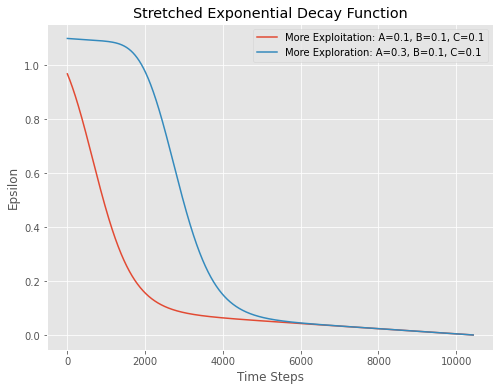

In [ ]:
# To visualise the decay graph
plt.figure(figsize=(8,6))
for key, value in params.items():
  A, B, C = value
  new_time=list(range(0,n_steps))
  y=[epsilon(time) for time in new_time]
  label = "{}: A={}, B={}, C={}".format(key, A, B, C)
  plt.plot(new_time,y,label=label)

plt.ylabel('Epsilon')
plt.xlabel('Time Steps')
plt.title('Stretched Exponential Decay Function')
plt.legend()
plt.savefig(bandit_root + "epsilon_decay_function.png", dpi=300)
plt.show()

### Run Simulations

In [ ]:
class EpsilonDecay():
    def __init__(self):
        self.counts = []
        self.values = []
        self.time = 0
        return
    
    def initialize(self, n_arms):
        self.counts = [0 for item in range(n_arms)]
        self.values = [0.0 for item in range(n_arms)]
        self.time = 0
        return
        
    def select_arm(self):
        if random.random() > epsilon(self.time):
            m = max(self.values)
            return self.values.index(m)
        else:
            return random.randrange(len(self.values))
    
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm] 
        value = self.values[chosen_arm]
        new_value = ((n-1)/float(n)) * value + (1/float(n)) * reward
        self.values[chosen_arm] = new_value
        self.time += 1
        return

In [ ]:
## Simulation and test
random.seed(4014)

epsilon_results = pd.DataFrame(columns=['n_sim','n_step','chosen_arm','rewards','cumulative_rewards','name'])

for key, value in params.items():
  A, B, C = value

  algo = EpsilonDecay()
  algo.initialize(n_arms)

  df = pd.DataFrame(test_algorithm(algo, arms, N_SIMULATIONS, n_steps)).transpose()
  df.columns=['n_sim','n_step','chosen_arm','rewards','cumulative_rewards']
  df['name'] = 'Epsilon Decay ({})'.format(key)

  epsilon_results = pd.concat([epsilon_results,df])

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 

In [ ]:
# # Optional: Save all simulations
# epsilon_results.to_csv(bandit_root + "simulate_epsilon_decay_all.csv", index=False)

In [ ]:
# # Optional: Load all simulations
# epsilon_results = pd.read_csv(bandit_root + "simulate_epsilon_decay_all.csv")

In [ ]:
# Aggregating results
epsilon_results['if_best_arm'] = np.where(epsilon_results['chosen_arm'] == test_mean.index(max(test_mean)),1,0)
epsilon_results_plot = epsilon_results.groupby(['name','n_step'],as_index=False).aggregate({'if_best_arm':lambda x: x.sum()/(x.count()+0.0),'rewards':'mean', 'cumulative_rewards':'mean'})

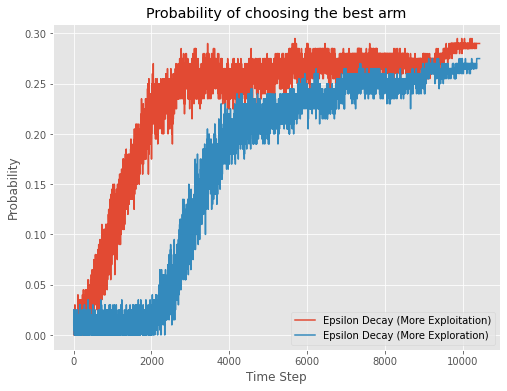

In [ ]:
# Plot for the best arm
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(111)
for name in epsilon_results_plot['name'].unique():
    ax.plot(epsilon_results_plot[epsilon_results_plot['name']==name]['n_step'],epsilon_results_plot[epsilon_results_plot['name']==name]['if_best_arm'], label=str(name))

plt.legend()
plt.title("Probability of choosing the best arm")
plt.xlabel("Time Step")
plt.ylabel("Probability")
plt.savefig(bandit_root + "epsilon_decay_best_arms.png", dpi=300)
plt.show()

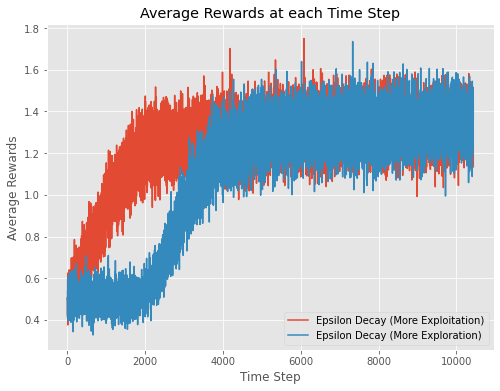

In [ ]:
# Plot for average rewards
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(111)
for name in epsilon_results_plot['name'].unique():
    ax.plot(epsilon_results_plot[epsilon_results_plot['name']==name]['n_step'],epsilon_results_plot[epsilon_results_plot['name']==name]['rewards'], label=str(name))

plt.legend()
plt.title("Average Rewards at each Time Step")
plt.xlabel("Time Step")
plt.ylabel("Average Rewards")
plt.savefig(bandit_root + "epsilon_decay_avg_rewards.png", dpi=300)
plt.show()

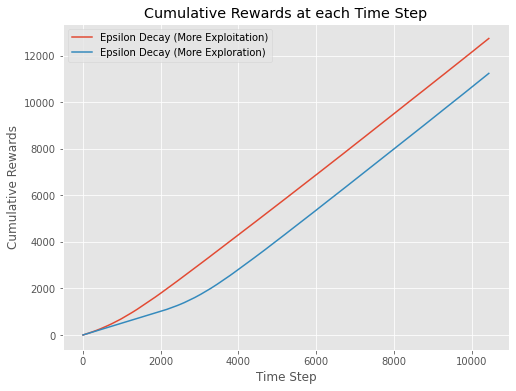

In [ ]:
# Plot for cumulative rewards
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(111)
for name in epsilon_results_plot['name'].unique(): 
    ax.plot(epsilon_results_plot[epsilon_results_plot['name']==name]['n_step'],epsilon_results_plot[epsilon_results_plot['name']==name]['cumulative_rewards'], label=str(name))

plt.legend()
plt.title("Cumulative Rewards at each Time Step")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Rewards")
plt.savefig(bandit_root + "epsilon_decay_cumulative_rewards.png", dpi=300)
plt.show()

In [ ]:
# Save the best performing results and formatting results
selected_params = {'More Exploitation': [0.1, 0.1, 0.1]}

for key, value in selected_params.items():
    A, B, C = value
    label = 'Epsilon Decay ({})'.format(key)
    selected_epsilon_results = epsilon_results.loc[epsilon_results['name'] == label].copy(deep=True)
    selected_epsilon_results.drop(columns=["if_best_arm"], inplace=True)
    selected_epsilon_results['name'] = 'Epsilon-Decay'

selected_epsilon_results.to_csv(bandit_root + "simulate_epsilon_decay.csv", index=False)

## Annealing Softmax

Annealing is the process of decreasing the temperature in a Softmax algorithm over time. It modifies a bandit algorithm’s behavior so that it will explore less over time.


In [ ]:
class AnnealingSoftmax():
    def __init__(self):
        self.counts = []
        self.values = []
        self.n_arms = 0
        return
    
    def initialize(self, n_arms):
        self.counts = [0 for item in range(n_arms)]
        self.values = [0.0 for item in range(n_arms)]
        self.n_arms = n_arms
        return
        
    def select_arm(self):
        temperature = 1/(1+math.log(sum(self.counts)+0.000001))
        z=sum([math.exp(v/temperature) for v in self.values])
        probs=[math.exp(v/temperature)/z for v in self.values]
        current_choice = np.random.choice(self.n_arms, p=probs)
        return current_choice
    
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm] 
        value = self.values[chosen_arm]
        new_value = ((n-1)/float(n))*value+(1/float(n))*reward
        self.values[chosen_arm] = new_value
        return

In [ ]:
## Simulation and test
random.seed(4014)
output = (bandit_root + "simulate_annealing_softmax.csv")

algo = AnnealingSoftmax()
algo.initialize(n_arms)

results = pd.DataFrame(test_algorithm(algo, arms, N_SIMULATIONS, n_steps)).transpose()
results.columns=['n_sim','n_step','chosen_arm','rewards','cumulative_rewards']
results['name'] = 'Annealing Softmax'
results.to_csv(output, index = False)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

## UCB1

In [ ]:
class UCB1():
    def __init__(self, counts, values):
        self.counts = counts
        self.values = values
        return

    def initialize(self, n_arms):
        self.counts = [0 for item in range(n_arms)]
        self.values = [0.0 for item in range(n_arms)]
        return

    def select_arm(self):
        n_arms = len(self.counts)
        for arm in range(n_arms):
            if self.counts[arm]==0:
                return arm

        ucb_values = [0.0 for arm in range(n_arms)]
        total_counts=sum(self.counts)
        for arm in range(n_arms):
            bonus = math.sqrt((2*math.log(total_counts))/(float(self.counts[arm])))
            ucb_values[arm] = self.values[arm] + bonus                        

        return ucb_values.index(max(ucb_values))

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm] 
        value = self.values[chosen_arm]
        new_value = ((n-1)/float(n))*value+(1/float(n))*reward
        self.values[chosen_arm] = new_value
        return

In [ ]:
## Simulation and test
random.seed(4014)
output = (bandit_root + "simulate_ucb1.csv")

algo = UCB1([],[])
algo.initialize(n_arms)

results = pd.DataFrame(test_algorithm(algo, arms, N_SIMULATIONS, n_steps)).transpose()
results.columns=['n_sim','n_step','chosen_arm','rewards','cumulative_rewards']
results['name'] = 'UCB1'
results.to_csv(output, index = False)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

## Bayesian UCB

### Define alpha, beta values

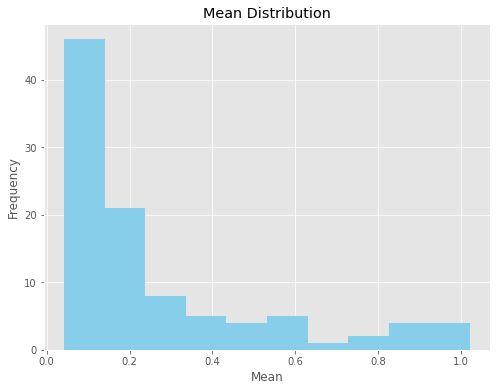

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(df.mean(), color='skyblue')
plt.title("Mean Distribution")
plt.xlabel('Mean')
plt.ylabel('Frequency')
plt.savefig(bandit_root + "bayesian_ucb_mean_distribution.png", dpi=300)
plt.show()

With the distribution as seen above, we try to find alpha and beta values similar to the Inverse Gamma distribution to determine.

![Inverse Gamma Probability Density Function (PDF)](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Inv_gamma_pdf.svg/600px-Inv_gamma_pdf.svg.png)

The most similar distribution will be alpha=3 and beta=0.5.

### Run Simulations

In [ ]:
class BayesUCB():
    def __init__(self,counts,values,stdnum=3,init_alpha=1,init_beta=1):
        self.counts = counts
        self.values = values
        self.stdnum = stdnum
        self.init_alpha = init_alpha
        self.init_beta = init_beta
        self.alphas = []
        self.betas = []
        return

    def initialize(self, n_arms):
        self.counts = [0 for item in range(n_arms)]
        self.values = [0.0 for item in range(n_arms)]
        self.alphas = [self.init_alpha]*n_arms
        self.betas = [self.init_beta]*n_arms
        return

    def select_arm(self):
        best_arm = max(
            range(len(self.counts)),
            key=lambda x: (self.betas[x] / float(self.alphas[x] - 1))
              + (invgamma.std(self.alphas[x], self.betas[x]) * self.stdnum)
        )  
        return best_arm

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1
        n = self.counts[chosen_arm] 
        value = self.values[chosen_arm]
        new_value = ((n-1)/float(n))*value+(1/float(n))*reward
        self.values[chosen_arm] = new_value
        # update alphas and betas
        self.alphas[chosen_arm] += (1/2)
        self.betas[chosen_arm] += ((reward-test_mean[chosen_arm])**2)/2
        return

In [ ]:
## Simulation and test
random.seed(4014)
output = (bandit_root + "simulate_bayes_ucb.csv")

algo = BayesUCB([],[],stdnum=3,init_alpha=3,init_beta=0.5)
algo.initialize(n_arms)

results = pd.DataFrame(test_algorithm(algo, arms, N_SIMULATIONS, n_steps)).transpose()
results.columns=['n_sim','n_step','chosen_arm','rewards','cumulative_rewards']
results['name'] = 'Bayesian UCB'
results.to_csv(output, index = False)

0 

## Thompson Sampling

In [ ]:
from numpy.random import Generator, PCG64
rg = Generator(PCG64())

class ThompsonSampling():  
    def __init__(self,counts,values,init_alpha,init_beta):
        self.counts = counts
        self.values = values
        self.init_alpha = init_alpha
        self.init_beta = init_beta
        self.alphas = []
        self.betas = []
        return
    
    def initialize(self, n_arms):
        self.counts = [0 for item in range(n_arms)]
        self.values = [0.0 for item in range(n_arms)]
        self.alphas = [self.init_alpha]*n_arms
        self.betas = [self.init_beta]*n_arms
        return
    
    def select_arm(self):
      thetas = []
      for x in range(len(self.counts)):
                thetas.append(1 / rg.gamma(self.alphas[x], 1/self.betas[x]))
      best_arm = max(
          range(len(self.counts)),
          key=lambda x: thetas[x]
      )                      
      return best_arm
    
    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] = self.counts[chosen_arm] + 1 
        n = self.counts[chosen_arm] 
        value = self.values[chosen_arm]
        new_value = ((n-1)/float(n))*value+(1/float(n))*reward
        self.values[chosen_arm] = new_value
        # update alphas and betas
        current_mean = test_mean[chosen_arm]
        self.alphas[chosen_arm] += (1/2)
        self.betas[chosen_arm] += ((reward-current_mean)**2)/2
        return

In [ ]:
## Simulation and test
random.seed(4014)
output = (bandit_root + "simulate_thompson_sampling.csv")

algo = ThompsonSampling([],[],init_alpha=3,init_beta=0.5)
algo.initialize(n_arms)

results = pd.DataFrame(test_algorithm(algo, arms, N_SIMULATIONS, n_steps)).transpose()
results.columns=['n_sim','n_step','chosen_arm','rewards','cumulative_rewards']
results['name'] = 'Thompson Sampling'
results.to_csv(output, index = False)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

## Performance Analysis

In [ ]:
# Import data
epsilon_decay_df = pd.read_csv(bandit_root + 'simulate_epsilon_decay.csv')
annealing_softmax_df = pd.read_csv(bandit_root + 'simulate_annealing_softmax.csv')
ucb1_df = pd.read_csv(bandit_root + 'simulate_ucb1.csv')
bayes_ucb_df = pd.read_csv(bandit_root + 'simulate_bayes_ucb.csv')
thompson_sampling_df = pd.read_csv(bandit_root + 'simulate_thompson_sampling.csv')

In [ ]:
# Merge all dfs together
all_results = pd.concat([epsilon_decay_df, annealing_softmax_df, 
                         ucb1_df, bayes_ucb_df, thompson_sampling_df])
all_results.sample(5)

,n_sim,n_step,chosen_arm,rewards,cumulative_rewards,name
1444021,139.0,3716.0,59.0,2.066751,4100.378589,Epsilon-Decay
1427503,137.0,8072.0,73.0,1.046677,9645.658089,Annealing Softmax
1616439,155.0,9142.0,90.0,0.252319,11676.991903,Thompson Sampling
83544,9.0,49.0,60.0,2.346841,16.487312,Thompson Sampling
1597261,154.0,401.0,30.0,1.843844,247.226519,UCB1


In [ ]:
test_mean = df.mean().tolist()
test_std = df.std().tolist()

In [ ]:
all_results['if_best_arm'] = np.where(all_results['chosen_arm']
                                      == test_mean.index(max(test_mean)), 1, 0)
results_plot = all_results.groupby(['name','n_step'],as_index=False) \
                          .aggregate(
                              {'if_best_arm':lambda x: x.sum()/(x.count()+0.0),
                              'rewards':'mean',
                              'cumulative_rewards':'mean'})

### Probability of Choosing the Best Arm

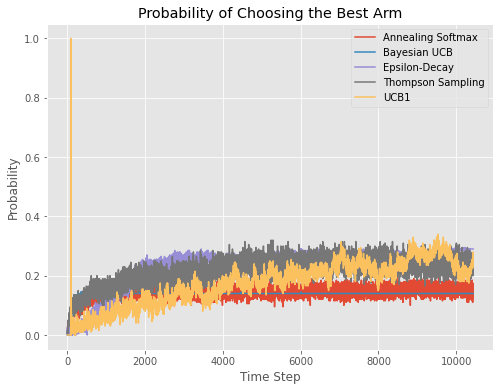

In [ ]:
# plot for the best arm
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(111)
for name in results_plot['name'].unique():
    ax.plot(results_plot[results_plot['name']==name]['n_step'],results_plot[results_plot['name']==name]['if_best_arm'], label=str(name))

plt.legend()
plt.title("Probability of Choosing the Best Arm")
plt.xlabel("Time Step")
plt.ylabel("Probability")
plt.savefig(bandit_root + 'best_arms.png', dpi=300)
plt.show()

### Average Rewards at each Time Step

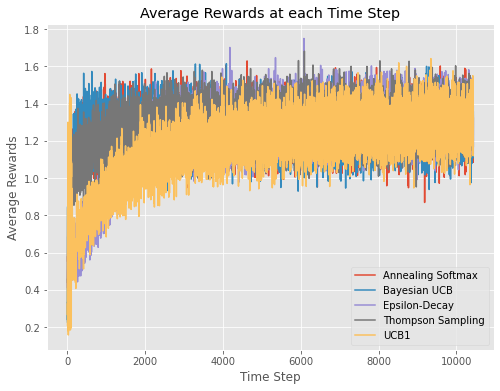

In [ ]:
# plot for average rewards
fig = plt.figure(figsize=(8, 6))


ax = fig.add_subplot(111)
for name in results_plot['name'].unique():
    ax.plot(results_plot[results_plot['name']==name]['n_step'],results_plot[results_plot['name']==name]['rewards'], label=str(name))

plt.legend()
plt.title("Average Rewards at each Time Step")
plt.xlabel("Time Step")
plt.ylabel("Average Rewards")
plt.savefig(bandit_root + 'avg_rewards.png', dpi=300)
plt.show()

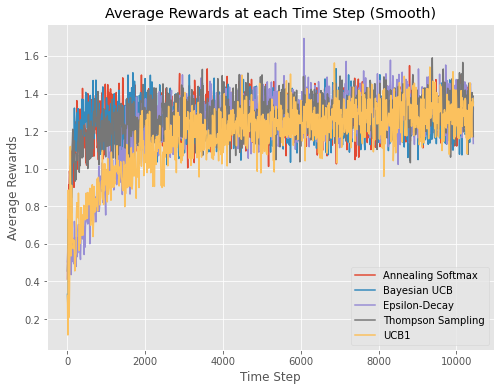

In [ ]:
# smoothen the lines to visualise more clearly

from scipy.interpolate import make_interp_spline, BSpline
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
for name in results_plot['name'].unique():
    x = results_plot[results_plot['name']==name]['n_step']
    newx = np.linspace(x.min(), x.max(), 1000) 
    y = results_plot[results_plot['name']==name]['rewards']
    spl = make_interp_spline(x, y, k=7)
    newy = spl(newx)
    ax.plot(newx,newy, label=str(name))
plt.legend()
plt.title('Average Rewards at each Time Step (Smooth)')
plt.xlabel("Time Step")
plt.ylabel("Average Rewards")
plt.savefig(bandit_root + 'avg_rewards_smooth.png', dpi=300)

### Cumulative Rewards at each Time Step

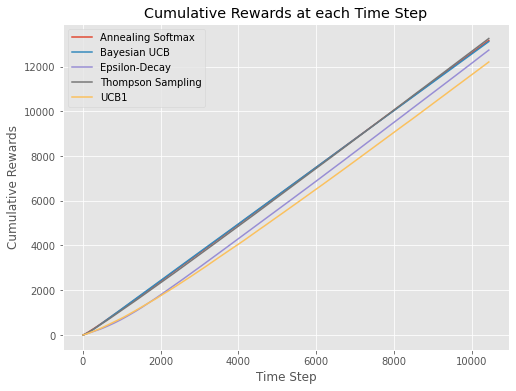

In [ ]:
# plot for cumulative rewards
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(111)
for name in results_plot['name'].unique(): 
    ax.plot(results_plot[results_plot['name']==name]['n_step'],results_plot[results_plot['name']==name]['cumulative_rewards'], label=str(name))

plt.legend()
plt.title("Cumulative Rewards at each Time Step")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Rewards")
plt.savefig(bandit_root + 'cumulative_rewards.png', dpi=300)
plt.show()